# exp004 - 高度な特徴量エンジニアリング

exp001-003の結果を踏まえ、名前、チケット、客室等からより高度な特徴量を抽出してモデル性能向上を目指す

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'IPAexGothic'

# データ読み込み
train_df = pd.read_csv('/Users/koki.ogai/Documents/ghq/github.com/oddgai/kaggle-projects/titanic/data/train.csv')
test_df = pd.read_csv('/Users/koki.ogai/Documents/ghq/github.com/oddgai/kaggle-projects/titanic/data/test.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (891, 12)
Test shape: (418, 11)


## 高度な特徴量エンジニアリング

In [2]:
def advanced_feature_engineering(df):
    df = df.copy()

    # 名前からの特徴量
    df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.')
    title_mapping = {
        'Mr': 'Mr', 'Mrs': 'Mrs', 'Miss': 'Miss', 'Master': 'Master',
        'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare',
        'Mlle': 'Miss', 'Countess': 'Rare', 'Ms': 'Mrs', 'Lady': 'Rare',
        'Jonkheer': 'Rare', 'Don': 'Rare', 'Dona': 'Rare', 'Mme': 'Mrs',
        'Capt': 'Rare', 'Sir': 'Rare'
    }
    df['Title_Grouped'] = df['Title'].map(title_mapping).fillna('Other')
    df['Name_Length'] = df['Name'].str.len()

    # 苗字と家族サイズ
    df['Surname'] = df['Name'].str.split(',').str[0]
    all_surnames = pd.concat([train_df['Name'], test_df['Name']]).str.split(',').str[0]
    surname_counts = all_surnames.value_counts()
    df['Surname_Count'] = df['Surname'].map(surname_counts)

    # チケット特徴量
    df['Ticket_Length'] = df['Ticket'].str.len()
    df['Ticket_IsNumeric'] = df['Ticket'].str.isnumeric().astype(int)
    df['Ticket_Prefix'] = df['Ticket'].str.extract(r'^([A-Za-z]+)').fillna('NUMERIC')

    all_tickets = pd.concat([train_df['Ticket'], test_df['Ticket']])
    ticket_counts = all_tickets.value_counts()
    df['Ticket_Count'] = df['Ticket'].map(ticket_counts)

    # 客室特徴量
    df['HasCabin'] = (~df['Cabin'].isnull()).astype(int)
    df['Cabin_Deck'] = df['Cabin'].str.extract(r'^([A-Za-z])').fillna('Unknown')
    df['Cabin_Number'] = df['Cabin'].str.extract(r'(\d+)').astype(float)
    df['Cabin_Count'] = df['Cabin'].fillna('').str.split().str.len()
    df.loc[df['Cabin'].isnull(), 'Cabin_Count'] = 0

    # 基本前処理
    df['Sex'] = df['Sex'].map({'female': 0, 'male': 1})
    df['Age'] = df.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))
    df['Fare'] = df.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))
    df['Embarked'] = df['Embarked'].fillna('S')

    # 家族構成
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    df['IsSmallFamily'] = ((df['FamilySize'] >= 2) & (df['FamilySize'] <= 4)).astype(int)
    df['IsLargeFamily'] = (df['FamilySize'] > 4).astype(int)

    # 年齢・運賃グループ
    df['Age_Group'] = pd.cut(df['Age'], bins=[0, 12, 18, 25, 35, 50, 65, 100], labels=[0,1,2,3,4,5,6])
    df['Fare_Group'] = pd.qcut(df['Fare'], q=8, labels=[0,1,2,3,4,5,6,7])

    # 交互作用
    df['Sex_Pclass'] = df['Sex'] * df['Pclass']
    df['Age_Fare_Interaction'] = df['Age'] * df['Fare']
    df['Age_FamilySize'] = df['Age'] * df['FamilySize']

    # 統計特徴量
    df['Age_Rank_SexPclass'] = df.groupby(['Sex', 'Pclass'])['Age'].rank(pct=True)
    df['Fare_Rank_Pclass'] = df.groupby('Pclass')['Fare'].rank(pct=True)

    return df

# 特徴量エンジニアリング実行
train_processed = advanced_feature_engineering(train_df)
test_processed = advanced_feature_engineering(test_df)

print(f"特徴量エンジニアリング後 - Train shape: {train_processed.shape}")
print(f"特徴量エンジニアリング後 - Test shape: {test_processed.shape}")

特徴量エンジニアリング後 - Train shape: (891, 36)
特徴量エンジニアリング後 - Test shape: (418, 35)


In [3]:
# カテゴリカル特徴量のエンコーディング
categorical_features = ['Embarked', 'Title_Grouped', 'Cabin_Deck', 'Ticket_Prefix']

for feature in categorical_features:
    if feature in train_processed.columns:
        le = LabelEncoder()
        all_categories = pd.concat([train_processed[feature], test_processed[feature]]).astype(str)
        le.fit(all_categories)

        train_processed[feature] = le.transform(train_processed[feature].astype(str))
        test_processed[feature] = le.transform(test_processed[feature].astype(str))

        print(f"{feature}: {len(le.classes_)} categories")

print("エンコーディング完了")

Embarked: 3 categories
Title_Grouped: 5 categories
Cabin_Deck: 9 categories
Ticket_Prefix: 21 categories
エンコーディング完了


In [4]:
# 特徴量選択
exclude_features = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived', 'Surname', 'Title']
feature_columns = [col for col in train_processed.columns
                  if col not in exclude_features and
                  train_processed[col].dtype in ['int64', 'float64', 'int32', 'float32']]

print(f"使用する特徴量数: {len(feature_columns)}")
print("特徴量一覧:")
for i, col in enumerate(feature_columns, 1):
    print(f"{i:2d}. {col}")

X = train_processed[feature_columns]
y = train_processed['Survived']
X_test = test_processed[feature_columns]

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X_test shape: {X_test.shape}")

使用する特徴量数: 27
特徴量一覧:
 1. Pclass
 2. Sex
 3. Age
 4. SibSp
 5. Parch
 6. Fare
 7. Embarked
 8. Title_Grouped
 9. Name_Length
10. Surname_Count
11. Ticket_Length
12. Ticket_IsNumeric
13. Ticket_Prefix
14. Ticket_Count
15. HasCabin
16. Cabin_Deck
17. Cabin_Number
18. Cabin_Count
19. FamilySize
20. IsAlone
21. IsSmallFamily
22. IsLargeFamily
23. Sex_Pclass
24. Age_Fare_Interaction
25. Age_FamilySize
26. Age_Rank_SexPclass
27. Fare_Rank_Pclass
X shape: (891, 27)
y shape: (891,)
X_test shape: (418, 27)


In [5]:
# モデル訓練
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

n_folds = 5
kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_scores = []
feature_importance = pd.DataFrame()
oof_predictions = np.zeros(len(X))
test_predictions = np.zeros(len(X_test))

print("交差検証開始")

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
    print(f"Fold {fold}/{n_folds}")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    model = lgb.train(
        lgb_params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
    )

    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)

    val_pred_binary = (val_pred >= 0.5).astype(int)
    fold_score = accuracy_score(y_val, val_pred_binary)
    cv_scores.append(fold_score)

    print(f"Fold {fold} Accuracy: {fold_score:.4f}")

    oof_predictions[val_idx] = val_pred
    test_predictions += test_pred / n_folds

    fold_importance = pd.DataFrame()
    fold_importance['feature'] = feature_columns
    fold_importance['importance'] = model.feature_importance()
    fold_importance['fold'] = fold
    feature_importance = pd.concat([feature_importance, fold_importance])

mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

print(f"CV Accuracy: {mean_cv_score:.4f} ± {std_cv_score:.4f}")

oof_binary = (oof_predictions >= 0.5).astype(int)
oof_accuracy = accuracy_score(y, oof_binary)
print(f"OOF Accuracy: {oof_accuracy:.4f}")

交差検証開始
Fold 1/5


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[153]	valid_0's rmse: 0.312114
Fold 1 Accuracy: 0.8771
Fold 2/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	valid_0's rmse: 0.34744
Fold 2 Accuracy: 0.8258
Fold 3/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[43]	valid_0's rmse: 0.373199
Fold 3 Accuracy: 0.8202
Fold 4/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[34]	valid_0's rmse: 0.355567
Fold 4 Accuracy: 0.8371
Fold 5/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	valid_0's rmse: 0.340483
Fold 5 Accuracy: 0.8708
CV Accuracy: 0.8462 ± 0.0234
OOF Accuracy: 0.8462


特徴量重要度 Top 15
Age_Fare_Interaction:    156.0
Name_Length         :    149.6
Age_Rank_SexPclass  :    145.4
Fare_Rank_Pclass    :    135.0
Fare                :    132.2
Age_FamilySize      :    115.8
Age                 :     92.0
Ticket_Length       :     49.8
Cabin_Number        :     49.6
Surname_Count       :     34.6
Ticket_Count        :     25.8
Sex                 :     25.6
Embarked            :     21.6
Pclass              :     21.4
Title_Grouped       :     19.0


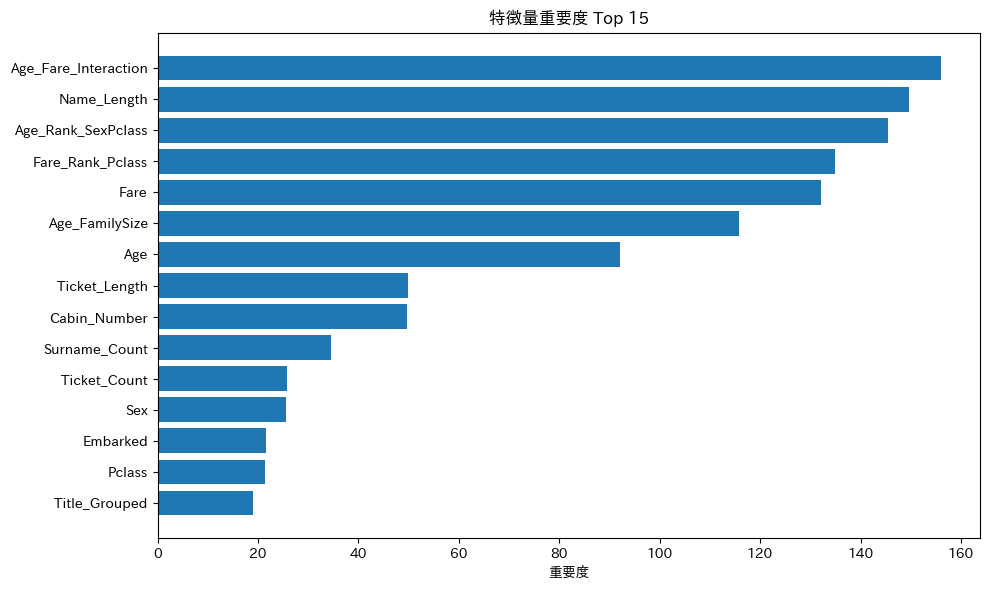

In [6]:
# 特徴量重要度
importance_agg = feature_importance.groupby('feature')['importance'].agg(['mean', 'std']).reset_index()
importance_agg = importance_agg.sort_values('mean', ascending=False)

print("特徴量重要度 Top 15")
for i, row in importance_agg.head(15).iterrows():
    print(f"{row['feature']:20s}: {row['mean']:8.1f}")

# 可視化
plt.figure(figsize=(10, 6))
top_features = importance_agg.head(15)
plt.barh(range(len(top_features)), top_features['mean'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('重要度')
plt.title('特徴量重要度 Top 15')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [7]:
# テストデータ予測
test_predictions_binary = (test_predictions >= 0.5).astype(int)

submission = pd.DataFrame({
    'PassengerId': test_processed['PassengerId'],
    'Survived': test_predictions_binary
})

submission.to_csv('/Users/koki.ogai/Documents/ghq/github.com/oddgai/kaggle-projects/titanic/results/exp004/result.csv', index=False)

print(f"生存予測数: {test_predictions_binary.sum()}")
print(f"死亡予測数: {len(test_predictions_binary) - test_predictions_binary.sum()}")
print(f"生存率: {test_predictions_binary.mean():.3f}")
print("提出ファイル保存完了")

print("="*50)
print("          EXP004 実験結果サマリー")
print("="*50)
print(f"使用特徴量数: {len(feature_columns)}")
print(f"CV Accuracy: {mean_cv_score:.4f} ± {std_cv_score:.4f}")
print(f"OOF Accuracy: {oof_accuracy:.4f}")
print("主要な新特徴量:")
print("- 敬称の詳細分類")
print("- 家族グループサイズ（苗字ベース）")
print("- グループチケット人数")
print("- 客室デッキ情報")
print("- 年齢・運賃の相対順位")
print()
print("ベースライン（exp001）との比較:")
print(f"exp001 CV: 0.8496 ± 0.026")
print(f"exp004 CV: {mean_cv_score:.4f} ± {std_cv_score:.4f}")
if mean_cv_score > 0.8496:
    print(f"→ 改善: +{mean_cv_score - 0.8496:.4f}")
else:
    print(f"→ 悪化: {mean_cv_score - 0.8496:.4f}")
print("="*50)

生存予測数: 144
死亡予測数: 274
生存率: 0.344
提出ファイル保存完了
          EXP004 実験結果サマリー
使用特徴量数: 27
CV Accuracy: 0.8462 ± 0.0234
OOF Accuracy: 0.8462
主要な新特徴量:
- 敬称の詳細分類
- 家族グループサイズ（苗字ベース）
- グループチケット人数
- 客室デッキ情報
- 年齢・運賃の相対順位

ベースライン（exp001）との比較:
exp001 CV: 0.8496 ± 0.026
exp004 CV: 0.8462 ± 0.0234
→ 悪化: -0.0034
